# EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

In [4]:
matplotlib inline

In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

# Part 1: Analyzing Best-Seller Trends Across Product Categories
* Objective: Understand the relationship between product categories and their best-seller status.

## 1. Crosstab Analysis:

- Create a crosstab between the product category and the isBestSeller status.

- Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

In [8]:
tabla_cruzada = pd.crosstab(df['category'], df['isBestSeller'])
tabla_cruzada

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [9]:
proporcion_bestsellers = tabla_cruzada[True] / (tabla_cruzada[True] + tabla_cruzada[False])
proporcion_bestsellers = proporcion_bestsellers.sort_values(ascending=False)
proporcion_bestsellers.head(10)

category
Grocery                           0.058135
Smart Home Security & Lighting    0.057692
Health & Personal Care            0.057686
Mobile Phone Accessories          0.042471
Power & Hand Tools                0.035339
Billiard, Snooker & Pool          0.032129
Pet Supplies                      0.030200
Home Brewing & Wine Making        0.028455
Mirrors                           0.028000
Wind Instruments                  0.028000
dtype: float64

##### las categorias donde hay best-sellers por cada libro

## 2. Statistical Tests:

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
- Compute Cramér's V to understand the strength of association between best-seller status and category.

In [10]:
from scipy.stats import chi2_contingency

In [11]:
chi2_stat, p_value, dof, expected = chi2_contingency(tabla_cruzada)

In [12]:
chi2_stat, p_value, dof

(np.float64(36540.20270061387), np.float64(0.0), 295)

In [13]:
# como p_value es < 0.05, rechazamos la hipótesis nula.
# Hay relacion significativa entre categoría y que sea o no un best seller

In [14]:
from scipy.stats.contingency import association

In [15]:
association(tabla_cruzada, method="cramer")

0.1222829439760564

In [16]:
#al ser un valor mas cercano al 0, se puede decir que tienen una relacion debil, la categoria influye pero poco

## 3. Visualizations:

- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [17]:
import matplotlib.pyplot as plt

In [18]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

In [19]:
top_20 = crosstab_result.sum(axis=1).sort_values(ascending=False).head(20).index
crosstab_top20 = crosstab_result.loc[top_20]

<Axes: xlabel='category'>

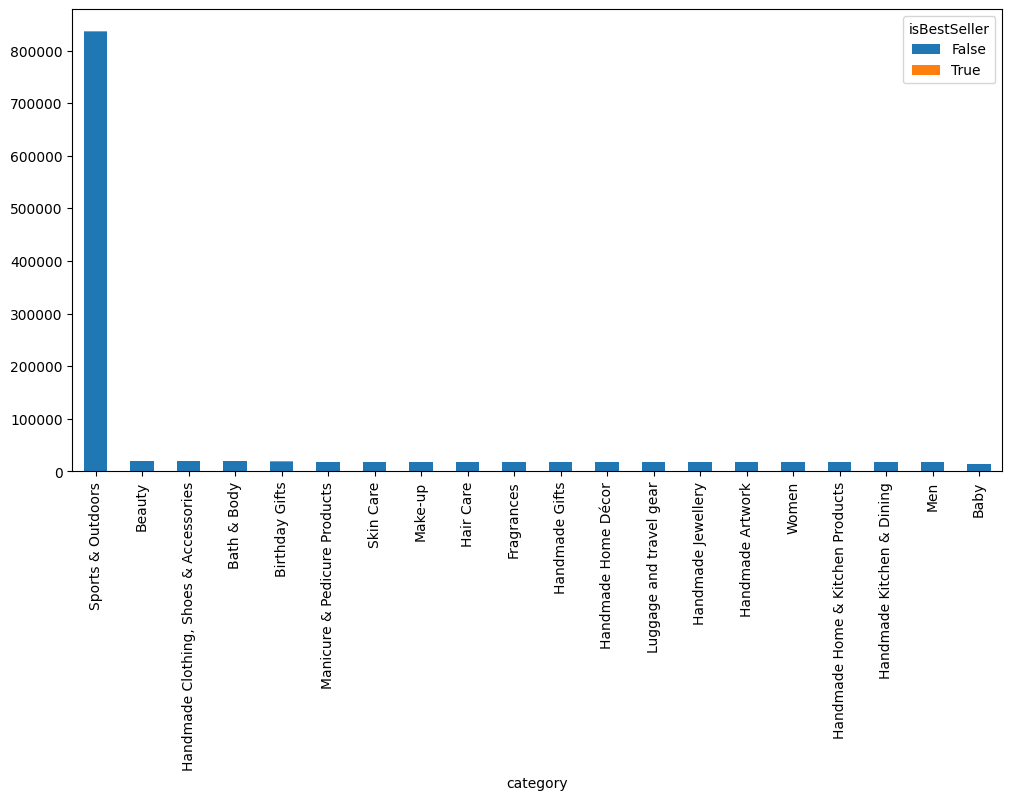

In [20]:
crosstab_top20.plot(kind="bar", stacked=True, figsize=(12,6))

<Axes: xlabel='category'>

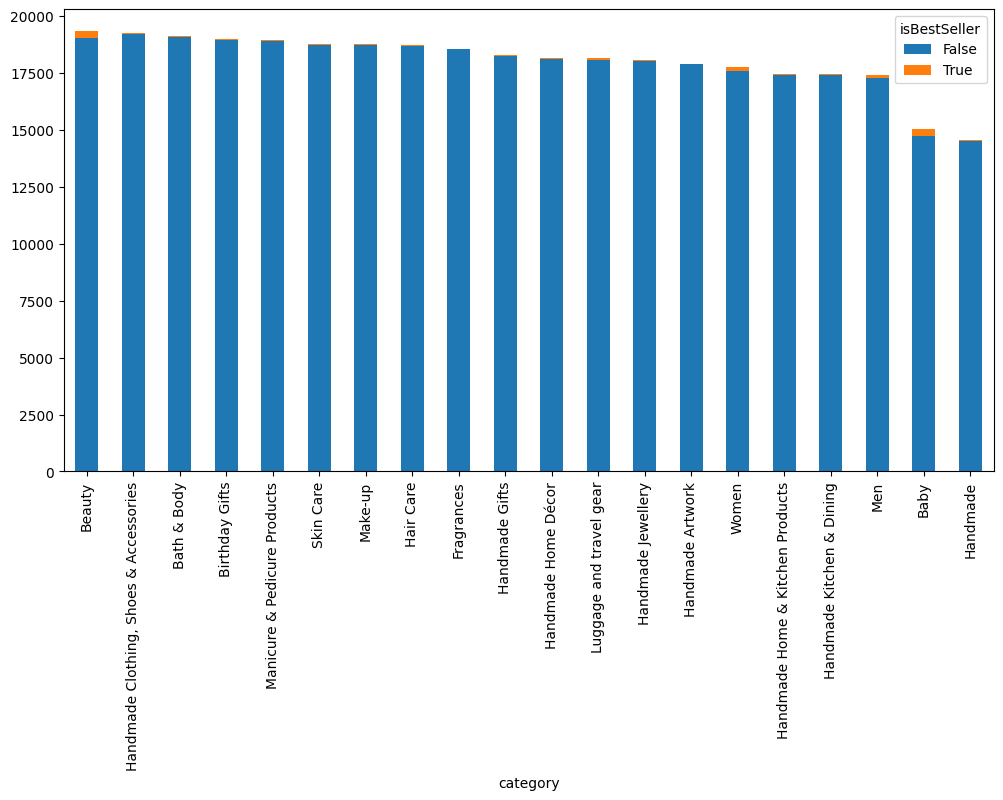

In [21]:
crosstab_filtrado = crosstab_result.drop(index='Sports & Outdoors', errors='ignore')
top_20_sin_sports = crosstab_filtrado.sum(axis=1).sort_values(ascending=False).head(20).index
crosstab_top20_sin_sports = crosstab_filtrado.loc[top_20_sin_sports]
crosstab_top20_sin_sports.plot(kind="bar", stacked=True, figsize=(12,6))


In [22]:
#en general hay poca cantidad de best-sellers,'Beauty', 'Women' o 'Baby' poco exito en best-sellers

# PART 2

### Preliminary Step: Remove outliers in product prices.

- For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [23]:
# Calcular Q1 y Q3
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)

# Calcular RIQ
riq = q3 - q1

# Calcular los límites inferior y superior
limite_inferior = q1 - 1.5 * riq
limite_superior = q3 + 1.5 * riq

print("Límite inferior:", limite_inferior)
print("Límite superior:", limite_superior)

# Crear un nuevo DataFrame sin los outliers
df_sin_outliers = df[(df['price'] >= limite_inferior) & (df['price'] <= limite_superior)]

# Ver cuántas filas quedan
print("Filas originales:", df.shape[0])
print("Filas sin outliers:", df_sin_outliers.shape[0])

Límite inferior: -44.01
Límite superior: 99.99000000000001
Filas originales: 2443651
Filas sin outliers: 2115963


In [24]:
# el inferior no puede ser negativo, asi que es 0 y los mayores a 99,99 se eliminan como outlier

## 1. Violin Plots:

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price? Don't filter here by top categories.

Text(0.5, 1.0, 'Distribución del precio por categoría (sin outliers, top 20)')

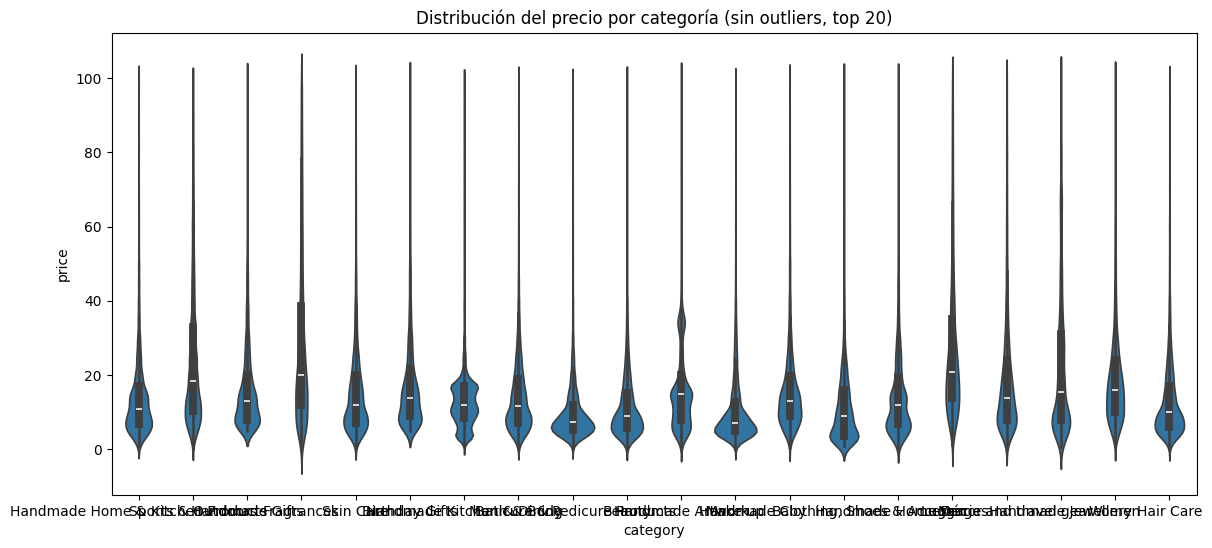

In [25]:
# 20 categorias mas frecuentes (usando el df sin outliers)
top_20_cat = df_sin_outliers['category'].value_counts().head(20).index

# filtramos el df para quedarnos solo con esas 20 categorías
df_violin = df_sin_outliers[df_sin_outliers['category'].isin(top_20_cat)]

# grafico de violin
plt.figure(figsize=(14, 6))
sns.violinplot(data=df_violin, x='category', y='price')
plt.title("Distribución del precio por categoría (sin outliers, top 20)")

In [26]:
#la mayoria tienen la mediana entre 10 y 20
#como eliminamos los precios altos, ninguna destaca por arriba
#violines mas altos y delgados dicen que los precios altos sin ser outliers
#violines más bajos y compactos tienen precios concentrados

## 2. Bar Charts:

- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
- Which product category commands the highest average price? Don't filter here by top categories.

C:\Users\BMENDI\AppData\Local\Temp\ipykernel_7208\3887031292.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=precios_top10.index, y=precios_top10.values, palette="Set3")


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Birthday Gifts'),
  Text(2, 0, 'Handmade Gifts'),
  Text(3, 0, 'Skin Care'),
  Text(4, 0, 'Bath & Body'),
  Text(5, 0, 'Hair Care'),
  Text(6, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(7, 0, 'Beauty'),
  Text(8, 0, 'Make-up'),
  Text(9, 0, 'Manicure & Pedicure Products')])

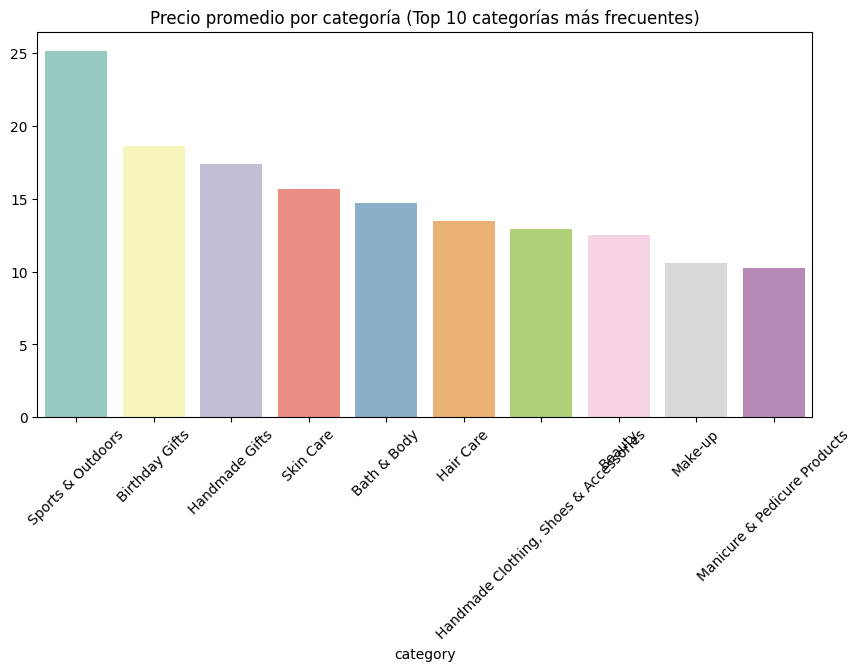

In [27]:
# Calcular el precio promedio por categoría
precios_promedio = df_sin_outliers.groupby('category')['price'].mean()

# Seleccionar las 10 categorías más frecuentes
top_10_cat = df_sin_outliers['category'].value_counts().head(10).index

# Filtrar solo esas categorías
precios_top10 = precios_promedio.loc[top_10_cat].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=precios_top10.index, y=precios_top10.values, palette="Set3")
plt.title("Precio promedio por categoría (Top 10 categorías más frecuentes)")
plt.xticks(rotation=45)

In [28]:
#las categorias con precios mas altos a mas bajos

## 3. Box Plots:

- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

C:\Users\BMENDI\AppData\Local\Temp\ipykernel_7208\2523747316.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxplot, x='category', y='stars', palette="Set3")


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Handmade Gifts'),
  Text(2, 0, 'Skin Care'),
  Text(3, 0, 'Birthday Gifts'),
  Text(4, 0, 'Bath & Body'),
  Text(5, 0, 'Manicure & Pedicure Products'),
  Text(6, 0, 'Beauty'),
  Text(7, 0, 'Make-up'),
  Text(8, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(9, 0, 'Hair Care')])

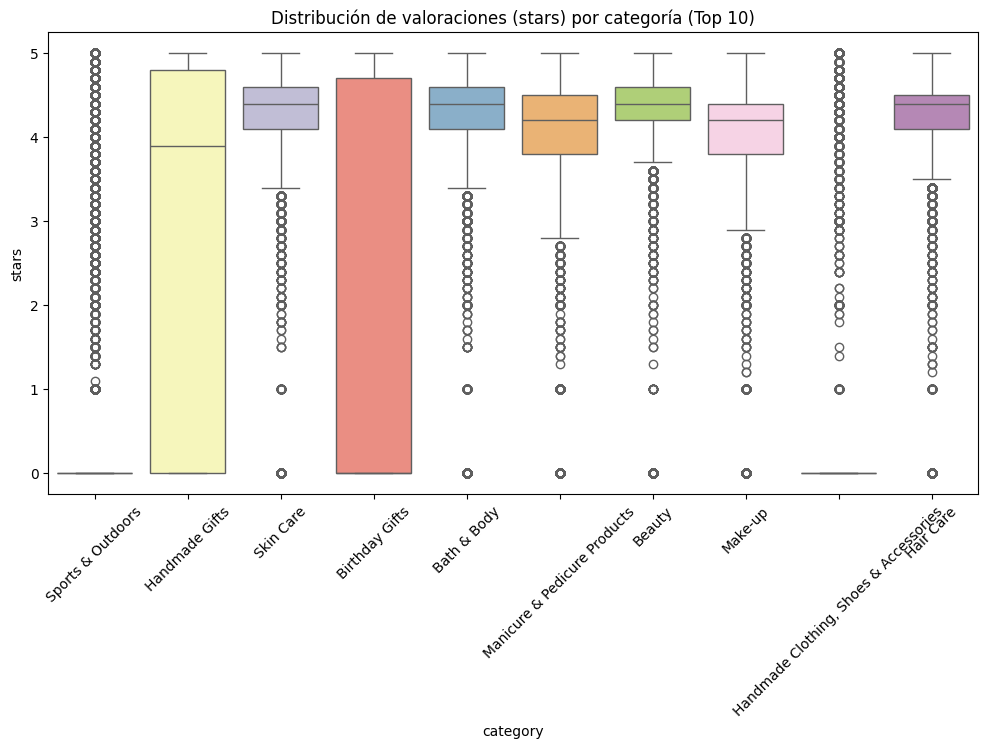

In [29]:
# Seleccionar las 10 categorías más frecuentes en df_sin_outliers
top_10_stars_cat = df_sin_outliers['category'].value_counts().head(10).index

# Filtrar solo esas categorías
df_boxplot = df_sin_outliers[df_sin_outliers['category'].isin(top_10_stars_cat)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_boxplot, x='category', y='stars', palette="Set3")
plt.title("Distribución de valoraciones (stars) por categoría (Top 10)")
plt.xticks(rotation=45)

In [ ]:
#Birthday Gifts, Handmade Gifts, Skin Care, Bath & Body, Beauty, Manicure & Pedicure Products tiene  medianas altas
#Por lo que sus valoraciones son altas de 4 o 5 estrellas

#Sports & Outdoors y Handmade Clothing, Shoes & Accessories la gente pone 0 o no las puntua y detecta 0.

# PARTE 3 Investigating the Interplay Between Product Prices and Ratings

## 1. Correlation Coefficients:

- Calculate the correlation coefficient between price and stars.
- Is there a significant correlation between product price and its rating?

In [31]:
df_sin_outliers['price'].corr(df_sin_outliers['stars'])

np.float64(-0.07767299878181444)

In [32]:
#no hay correlacion entre price y stars, el precio no influye en la valoración del producto

## 2. Visualizations:

- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
- Use a correlation heatmap to visualize correlations between all numerical variables.
- Examine if product prices typically follow a normal distribution using a QQ plot.

Text(0.5, 1.0, 'Relación entre precio y valoración (sin outliers)')

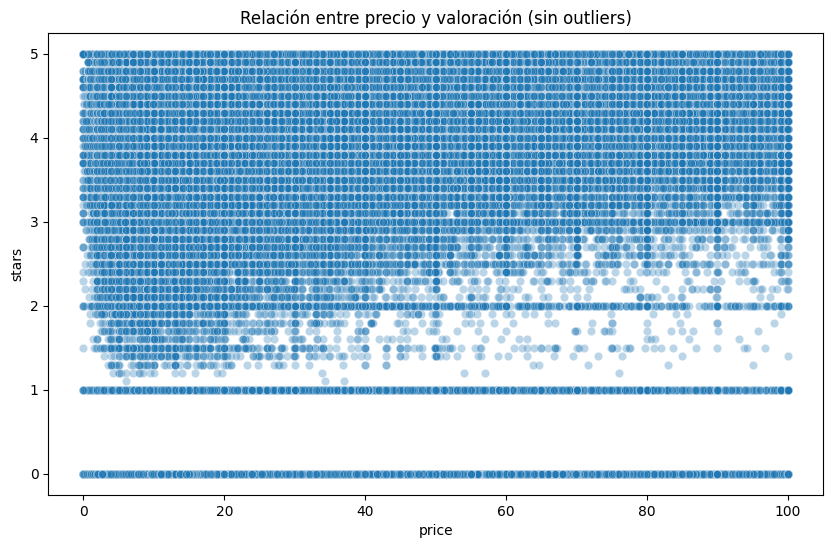

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sin_outliers, x='price', y='stars', alpha=0.3)
plt.title("Relación entre precio y valoración (sin outliers)")

In [34]:
#confirmamos que precio no tiene relacion directa con la valoracion del producto

<Axes: >

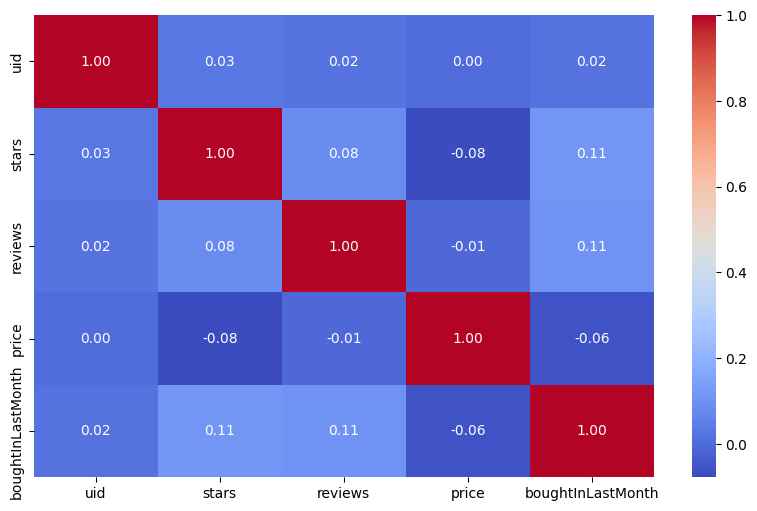

In [35]:
# Seleccionamos solo las columnas numéricas
numericas = df_sin_outliers.select_dtypes(include='number')

# Calculamos la matriz de correlación
matriz_corr = numericas.corr()

# Dibujamos el mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", fmt=".2f")


In [36]:
#Correlaciones muy bajas en general
#productos con mejores valoraciones se compran un poco mas
#productos mas caros tienden ligeramente a tener menos valoraciones positivas y menos compras

In [37]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


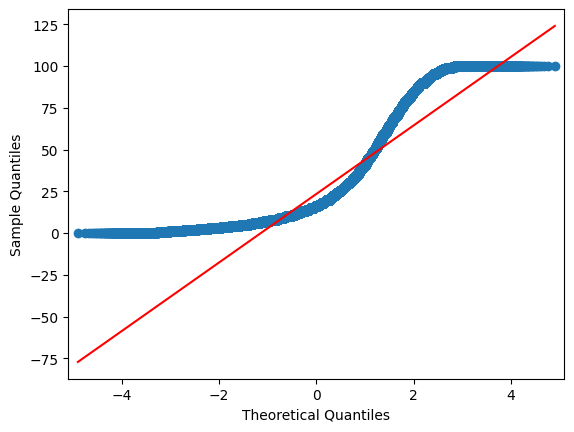

In [40]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'SalePrice' to check if its distribution follows a normal distribution
sm.qqplot(df_sin_outliers['price'], line='s');

In [ ]:
#  forma simetrica positiva general
#las colas se desvian de la distribucion normal ideal 